# Denoising Diffusion Probabilistic Model
### [Team 25] Youngmin Ryou, ChulHyun Hwang

Main contribution


*   Reproduce the results of the paper using CIFAR10 dataset
*   experiment the effect of using **adaptive Weight** to the loss function

In [1]:
!pip install einops
!pip install torchmetrics
!pip install scipy
!pip install torch-fidelity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 403 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 28.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Set root dir

In [2]:
from google.colab import drive
drive.mount('/gdrive')

# Edit this root directory!!! ===================================
# root = "/gdrive/MyDrive/"

Mounted at /gdrive


## set the result_dir to the directory where the model parameter exists.

In [3]:
import torch, einops
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time

# Edit This result directory to the directory where the pretrained weights of the diffuser model exists.
# result_dir = r'/gdrive/'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Helper functions

In [4]:
def save_model(model, result_dir, mode='last'):
    """
        save model to result.

    """
    torch.save(model.state_dict(), os.path.join(result_dir,  f'ddpm_{mode}.ckpt'))

def load_model(model, result_dir, mode='last'):
    """
        load model from result_dir 
    """
    if os.path.exists(os.path.join(result_dir , f'ddpm_{mode}.ckpt')):
        model.load_state_dict(torch.load(os.path.join(result_dir , f'ddpm_{mode}.ckpt')))

### Blocks in Unet

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=8, dropout=0.1, t_emb_dim = 512, with_attention = False):
        """
            according to the paper, we use resnet block with 2 cnn layers with 1 group normalization layer between the cnn layers.
            and use linear layer for positional embedding.

        """

        super(ResBlock, self).__init__()
        
        self.gn_in = nn.GroupNorm(num_groups, in_channels, affine=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride = 1, padding = 1)
        self.with_attention = with_attention
        if with_attention: # for 16*16 level of the unet back bone, add attention layer b.w convoluiton layers.
            self.attn_gn = nn.GroupNorm(num_groups, out_channels, affine=True)
            self.attn = Attention(out_channels)
            self.attn_dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride = 1, padding = 1)
        self.gn1 = nn.GroupNorm(num_groups, in_channels, affine=True)
        self.gn2 = nn.GroupNorm(num_groups, out_channels, affine=True)
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(dropout)

        # if input channel != output channel, use 1*1 conv to match the shape of the input and output for the residual connection.
        self.is_res_proj = (in_channels != out_channels)
        if (in_channels != out_channels):
            self.res_proj = nn.Conv2d(in_channels, out_channels, kernel_size = 1) 

        self.t_emb_dim = t_emb_dim
        if t_emb_dim is not None:
            self.time_proj = nn.Linear(t_emb_dim, out_channels)
        
    def forward(self, x, pe):
        # print("h size before con1", x.shape)
        h = self.conv1(self.act(self.gn_in(x)))
        if self.t_emb_dim is not None:
            # print("proj")
            pe = self.time_proj(self.act(pe))
        # print("h size after con1", h.shape)
        # print("forwarding: pe shaep", pe.shape)
        pe=pe.reshape(h.shape[0], h.shape[1], 1, 1)
        h = h + pe
        if self.with_attention:
            h=self.attn_dropout(
                self.attn(
                    self.act(
                        ( 
                        self.attn_gn(h)
                        ))))
        
        h = self.conv2(self.act( self.gn2(h) ) )
        if self.is_res_proj:
            x = self.res_proj(x)
        out = h + x
        return out
        
class Attention(nn.Module):
    def __init__(self, input_channels, num_heads = 8, num_hidden = 32, dropout=0.1):
        """
            multi-head attention block in the transformer paper.
        """
        super(Attention, self).__init__()

        self.num_heads = num_heads
        self.num_hidden = num_hidden
        self.scaling = num_hidden ** (-1/2)
        self.lin_fgh = nn.Linear(input_channels, 3*num_heads*num_hidden)
        self.lin_v = nn.Linear(num_heads*num_hidden, input_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, pe=None):
        image_size = x.shape[-1]
        x = einops.rearrange(x, 'b c h w -> b (h w) c')
        fgh = self.lin_fgh(x)
        fgh = einops.rearrange(fgh, 'b n c -> b c n')
        f, g, h = fgh.chunk(3, dim = 1)

        
        f = einops.rearrange(f, 'b (head hidden) n -> b head hidden n', head=self.num_heads)
        g = einops.rearrange(g, 'b (head hidden) n -> b head hidden n', head=self.num_heads)
        h = einops.rearrange(h, 'b (head hidden) n -> b head hidden n', head=self.num_heads)
        
        
        s = einops.einsum(f, g, 'b head hidden n1, b head hidden n2 -> b head n1 n2')*self.scaling
        s = F.softmax(s, dim=-1)
        s = self.dropout(s)

        o = einops.einsum(s, h, 'b head n1 n2, b head hidden n1 -> b head hidden n2')
        o = einops.rearrange(o, 'b head hidden n -> b n (head hidden)')
        out = self.lin_v(o)
        return einops.rearrange(out, 'b (h w) c -> b c h w', h = image_size)


class DownScaling(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        downscaling layer with strided convolution. downscale the size of the image as 1/2
        """
        super(DownScaling, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2)
    
    def forward(self, x, pe=None):
        return self.conv(x)

class Upscaling(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        upscaling layer with transpose deconvolution with stride 2
        """
        super(Upscaling, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x, pe=None):
        return self.upconv(x)

def sinusoidalPosEnc(max_len:int, times, out_channels:int, device=device):
    """
    max_len: int
    image_dim: int
    times: (b) int list

    return: (b, c,)
    """
    
    i = torch.arange(0, out_channels // 2).to(device)
    denom = 10000 ** (2*i / out_channels)
    denom = einops.repeat(denom, "c -> b c", b = len(times))
    times = times.reshape(len(times),1)
    
    pe = torch.zeros([len(times), out_channels])
    pe[:, 0::2] = torch.sin(times / denom).to(device)
    pe[:, 1::2] = torch.cos(times / denom).to(device)
    pe = pe.type(torch.float32)
    return pe.to(device)


In [6]:
class Unet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        in_size: int = 32, 
        out_size: int = 32,
        num_channels=(128, 128, 256, 256, 512,),
        num_groups: int=8,
        positional_encoding_type: str = "sinusoidal",
        max_time: int = 1000,
        t_emb_dim = 512,
        time_embedding_proj = True
        ):

        """
        Description
            Unet backbone model. get input image and timestep t, and returns the the same dimesion of image output.

        Parameters
        
            in_channels: input image channels
            out_channels: output image channels
            in_size: input image size (h=w=in_size)
            out_size: output image size (h=w=out_size)
            num_channels: number of feature channels in Unet layers.
            num_groups: parameter to group normalization in each res blocks.
            positional_encoding_type: sinusoidal transformer positional encoding or something. currently, only "sinusoidal" is implementd.
            max_time: the number of time steps in the diffuser model.
            t_emb_dim: time embedding dimension used for the learned time embedding. only used when time_embedding_proj = True
            time_embedding_proj: if True, use learned linear time embedding projection to encode the time information.
        """

        super(Unet, self).__init__()
        self.max_time = max_time

        num_dims = len(num_channels)-1
        self.t_emb_dim = t_emb_dim

    
        self.conv1 = nn.Conv2d(in_channels, num_channels[0], 3, stride=1, padding=1)

        self.downs = nn.ModuleList([]) # down scaling layers
        self.ups = nn.ModuleList([]) # upscaling layers
        self.act = nn.SiLU() # the activation function

        # define downscaling step
        for i in range(1, len(num_channels)-1):
            if (in_size / (2**(i-1))) == 16: # 16*16 layer, the paper added attention block between resnet conv blocks.
                self.downs.append(
                    nn.ModuleList([
                        ResBlock(num_channels[i], num_channels[i], t_emb_dim = self.t_emb_dim, with_attention=True),
                        ResBlock(num_channels[i], num_channels[i], t_emb_dim = self.t_emb_dim, with_attention=True),
                        DownScaling(num_channels[i], num_channels[i+1])
                    ])
                )
            else:
                self.downs.append(
                    nn.ModuleList([
                        ResBlock(num_channels[i], num_channels[i], t_emb_dim = self.t_emb_dim),
                        ResBlock(num_channels[i], num_channels[i], t_emb_dim = self.t_emb_dim ),
                        DownScaling(num_channels[i], num_channels[i+1]),
                    ])
                )


        # define middle step
        self.mid = nn.ModuleList([
            ResBlock(num_channels[-1], num_channels[-1], t_emb_dim = self.t_emb_dim),
            ResBlock(num_channels[-1], num_channels[-1], t_emb_dim = self.t_emb_dim),
            Upscaling(num_channels[-1], num_channels[-2])
        ])

        # define upscaling step
        for i in range(len(num_channels)-2, 0, -1):
            if i == (len(num_channels)-1): # 16*16 layer
                self.ups.append(
                    nn.ModuleList([
                        # due to the skip connection, we need 2*num_channels[i] input channels
                        ResBlock(num_channels[i]*2, num_channels[i], t_emb_dim = self.t_emb_dim,with_attention=True), 
                        ResBlock(num_channels[i], num_channels[i], t_emb_dim = self.t_emb_dim,with_attention=True),
                        Upscaling(num_channels[i], num_channels[i-1])
                    ])
                )
            elif i == 1:
                self.ups.append( # the last layer, we don't need upscaling layer.
                    nn.ModuleList([
                        # due to the skip connection, we need 2*num_channels[i] input channels
                        ResBlock(num_channels[i]*2, num_channels[i], t_emb_dim = self.t_emb_dim,),
                        ResBlock(num_channels[i], num_channels[i], t_emb_dim = self.t_emb_dim),
                        
                    ])
                )
            else:
                self.ups.append(
                    nn.ModuleList([
                        # due to the skip connection, we need 2*num_channels[i] input channels
                        ResBlock(num_channels[i]*2, num_channels[i],t_emb_dim = self.t_emb_dim),
                        ResBlock(num_channels[i], num_channels[i],t_emb_dim = self.t_emb_dim),
                        Upscaling(num_channels[i], num_channels[i-1])
                    ])
                )
        # last projection
        self.last_proj = nn.Conv2d(num_channels[0], out_channels=out_channels, kernel_size = 3, padding = 1)
        self.time_encoding_dimension = num_channels[0]
        self.time_embedding_proj = time_embedding_proj

        if self.time_embedding_proj:
            self.time_emb_projection1 = nn.Linear(self.time_encoding_dimension, self.t_emb_dim)
            self.time_emb_projection2 = nn.Linear(self.t_emb_dim, self.t_emb_dim)

            
        
    def forward(self, x, t):
        # time embedding
        pe = sinusoidalPosEnc(self.max_time, t, self.time_encoding_dimension, device)
        pe = self.time_emb_projection2(self.act((self.time_emb_projection1(pe))))
        # initial projection
        h = self.conv1(x)
        
        # store hidden states during the downscaling, for the skip connection
        down_hs = []

        for d in self.downs:
            for i, l in enumerate(d):
                h=l(h, pe)
                if i == (len(d)-2):
                    down_hs.append(h)
        
        for l in self.mid:
            h = l(h, pe)

        for i, u in enumerate(self.ups):
            h = torch.cat([h, down_hs[-i-1]], dim=1) # the skip connection
            for l in u:
                h = l(h, pe)
        # last projection
        out = self.last_proj(h)
        
        return out



### Diffuser with forward and backward process
forward(x0, t) -> xt, eps

predict(xt, t) -> target 
 - target can be 'x0' or 'eps'
 - predict the target value with the unet model

reverse(xt, t) -> x0
 - starting from xt with time step t, predict x0 with sequential reverse process.
 - it is for inference, not training.

In [7]:
class Diffuser(nn.Module):
    def __init__(self, model:nn.Module, beta_1:float = 1e-4, beta_T:float=0.02, scheduler="linear", target="noise", is_adaptive_weight=False):
        """
            The diffuser class with the forward step and the reverse step.

        Parameters
            model: the Unet back bone model
            beta_1: the inital beta value at time step 1. we use linear scheduling for the beta value in the forward step.
            beta_T: the last beta value at time step T. we use linear scheduling for the beta value in the forward step.
            scheduler: The kind of scheduler for the forward step variance. only "linear" is implemented.
            target: The target that the backbone model will predict. "noise" and "x0" is available. We didn't test the "x0" case. only "noise" is tested.
            is_adaptive_weight: If True, we use adaptive weight for loss terms during the training phase.
        """
        super(Diffuser, self).__init__()
        self.model = model

        self.is_adaptive_weight = is_adaptive_weight
        if is_adaptive_weight:
            self.loss_weights = nn.parameter.Parameter(torch.ones((model.max_time,1)), requires_grad=True)

        if (target == "noise") or (target == "x0"):
            self.target = target
        else:
            raise NotImplementedError(f"target {target} is not implemented. use 'noise' or 'x0'.")
            
        self.max_time = model.max_time
        self.beta = self.beta_scheduler(beta_1, beta_T, scheduler)
        self.beta = self.beta.to(device)
        self.alpha = 1 - self.beta
        # cummulative products of alphas
        self.cum_alpha = torch.cumprod(self.alpha, dim=0)
        # square root of cummulative products of alphas
        self.sqrt_cum_alpha = self.cum_alpha ** (1/2)
        # square root of (1- cummulative products of alphas)
        self.sqrt_resid_cum_alpha = ((1-self.cum_alpha)**(1/2))
        # reverse diffuse step variance are set to be the same with beta (by paper)
        self.variance_reverse = self.beta

    def freeze_loss_weights(self):
        """
            Freeze adaptive loss weight of the diffuser.
        """
        if not self.is_adaptive_weight:
            raise NotImplementedError("there is no loss weights.")
        self.loss_weights.requires_grad = False

    def unfreeze_loss_weights(self):
        """
            unfreeze adaptive loss weight of the diffuser.
        """

        if not self.is_adaptive_weight:
            raise NotImplementedError("there is no loss weights.")
        self.loss_weights.requires_grad = True
        

    def beta_scheduler(self, beta_1:float, beta_T:float, scheduler="linear"):
        """
            generate the sequence of beta, the variance of each noise step.
        """
        if scheduler != "linear":
            raise NotImplementedError(f"the scheduler type {scheduler} is not implemented.")
        assert(beta_1 < beta_T)
        return torch.linspace(beta_1, beta_T, self.max_time)
        
    def get_forward_diffused_image(self, x0, t, return_noise=True):
        """
            return noised image xt from x0.
        """
        stds = self.sqrt_resid_cum_alpha[t].reshape(-1,1,1,1)
        noise = torch.randn_like(x0).to(device)
        mean_scales = self.sqrt_cum_alpha[t].reshape(-1,1,1,1)
        
        return (mean_scales*x0 + stds*noise, noise) if return_noise else mean_scales*x0 + stds*noise
        
    def forward(self, xt, t):
        """
            predict the target (x0 or noise) with the unet backbone model. 
        Parameters
            xt: diffused images at time step t. torch tensor with size (B,C,H,W)
            t: time step of xt. torch tensor with size (B,)
        """
        return self.model(xt, t)

    def batch_reverse_diffuse(self, xt, t, return_history=False):
        """
            apply reverse process to xt and returns X0.

        Parameters
            xt: diffused images at time step t. torch tensor with size (B,C,H,W)
            t: time step of xt. torch tensor with size (B,). all elements of t must be the same. e.g. t=torch.Tensor([1000,1000,1000,...,1000])
            return_history: if True, this function returns X0 and history of the reverse process.
        """
        with torch.no_grad():
            if self.target == "x0":
                return self.model(xt, t)
            if return_history:
                history = []

            img = xt
            for i in range(t[0].item(), -1, -1):
                eps = self.model(img, t)
                t = t - 1 

                if i == 0:
                    img = (img - (1-self.alpha[i])/self.sqrt_resid_cum_alpha[i] * eps ) / (self.alpha[i] ** (1/2))
                else:
                    z = torch.randn_like(img).cuda()
                    img = (img - (1-self.alpha[i])/self.sqrt_resid_cum_alpha[i] * eps ) / (self.alpha[i] ** (1/2)) + (self.variance_reverse[i] ** (1/2))*z
                
                if return_history:
                    history.append(img)
                
            if return_history:
                return img, torch.stack(history)
            else:
                return img
            

### Check input and output dimensions

In [8]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=8, dropout=0.1, t_emb_dim = 512, with_attention = False):
        """
            according to the paper, we use resnet block with 2 cnn layers with 1 group normalization layer between the cnn layers.
            and use linear layer for positional embedding.

        """

        super(ResBlock, self).__init__()
        
        self.gn_in = nn.GroupNorm(num_groups, in_channels, affine=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride = 1, padding = 1)
        self.with_attention = with_attention
        if with_attention: # for 16*16 level of the unet back bone, add attention layer b.w convoluiton layers.
            self.attn_gn = nn.GroupNorm(num_groups, out_channels, affine=True)
            self.attn = Attention(out_channels)
            self.attn_dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride = 1, padding = 1)
        self.gn1 = nn.GroupNorm(num_groups, in_channels, affine=True)
        self.gn2 = nn.GroupNorm(num_groups, out_channels, affine=True)
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(dropout)

        # if input channel != output channel, use 1*1 conv to match the shape of the input and output for the residual connection.
        self.is_res_proj = (in_channels != out_channels)
        if (in_channels != out_channels):
            self.res_proj = nn.Conv2d(in_channels, out_channels, kernel_size = 1) 

        self.t_emb_dim = t_emb_dim
        if t_emb_dim is not None:
            self.time_proj = nn.Linear(t_emb_dim, out_channels)
        
    def forward(self, x, pe):
        # print("h size before con1", x.shape)
        h = self.conv1(self.act(self.gn_in(x)))
        if self.t_emb_dim is not None:
            # print("proj")
            pe = self.time_proj(self.act(pe))
        # print("h size after con1", h.shape)
        # print("forwarding: pe shaep", pe.shape)
        pe=pe.reshape(h.shape[0], h.shape[1], 1, 1)
        h = h + pe
        if self.with_attention:
            h=self.attn_dropout(
                self.attn(
                    self.act(
                        ( 
                        self.attn_gn(h)
                        ))))
        
        h = self.conv2(self.act( self.gn2(h) ) )
        if self.is_res_proj:
            x = self.res_proj(x)
        out = h + x
        return out
        
class Attention(nn.Module):
    def __init__(self, input_channels, num_heads = 8, num_hidden = 32, dropout=0.1):
        """
            multi-head attention block in the transformer paper.
        """
        super(Attention, self).__init__()

        self.num_heads = num_heads
        self.num_hidden = num_hidden
        self.scaling = num_hidden ** (-1/2)
        self.lin_fgh = nn.Linear(input_channels, 3*num_heads*num_hidden)
        self.lin_v = nn.Linear(num_heads*num_hidden, input_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, pe=None):
        image_size = x.shape[-1]
        x = einops.rearrange(x, 'b c h w -> b (h w) c')
        fgh = self.lin_fgh(x)
        fgh = einops.rearrange(fgh, 'b n c -> b c n')
        f, g, h = fgh.chunk(3, dim = 1)

        
        f = einops.rearrange(f, 'b (head hidden) n -> b head hidden n', head=self.num_heads)
        g = einops.rearrange(g, 'b (head hidden) n -> b head hidden n', head=self.num_heads)
        h = einops.rearrange(h, 'b (head hidden) n -> b head hidden n', head=self.num_heads)
        
        
        s = einops.einsum(f, g, 'b head hidden n1, b head hidden n2 -> b head n1 n2')*self.scaling
        s = F.softmax(s, dim=-1)
        s = self.dropout(s)

        o = einops.einsum(s, h, 'b head n1 n2, b head hidden n1 -> b head hidden n2')
        o = einops.rearrange(o, 'b head hidden n -> b n (head hidden)')
        out = self.lin_v(o)
        return einops.rearrange(out, 'b (h w) c -> b c h w', h = image_size)


class DownScaling(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        downscaling layer with strided convolution. downscale the size of the image as 1/2
        """
        super(DownScaling, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2)
    
    def forward(self, x, pe=None):
        return self.conv(x)

class Upscaling(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        upscaling layer with transpose deconvolution with stride 2
        """
        super(Upscaling, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x, pe=None):
        return self.upconv(x)

def sinusoidalPosEnc(max_len:int, times, out_channels:int, device=device):
    """
    max_len: int
    image_dim: int
    times: (b) int list

    return: (b, c,)
    """
    
    i = torch.arange(0, out_channels // 2).to(device)
    denom = 10000 ** (2*i / out_channels)
    denom = einops.repeat(denom, "c -> b c", b = len(times))
    times = times.reshape(len(times),1)
    
    pe = torch.zeros([len(times), out_channels])
    pe[:, 0::2] = torch.sin(times / denom).to(device)
    pe[:, 1::2] = torch.cos(times / denom).to(device)
    pe = pe.type(torch.float32)
    return pe.to(device)


## Load diffuser
You need to choose whether you will use adaptive loss or not

In [9]:
# If you are training adaptive weight diffuser, decomment below
"""
model = Unet(3,3, ).to(device)
diffuser = Diffuser(model, is_adaptive_weight=True).to(device)
"""
# else, decomment below:
model = Unet(3,3, ).to(device)
diffuser = Diffuser(model, is_adaptive_weight=True).to(device)


# Report the number of trainable parameters
trainable_params = sum(
	p.numel() for p in diffuser.parameters() if p.requires_grad
)
print(trainable_params)

26247275


In [10]:
load_model(diffuser, result_dir, 'best')

Draw predetermined weights

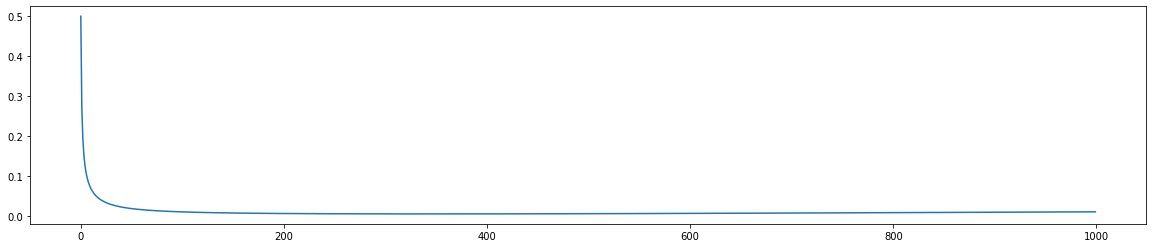

In [11]:
vb_weights = (diffuser.beta / (2*diffuser.alpha*(1-diffuser.cum_alpha)))

plt.figure(figsize=(20,4))
weights = vb_weights
weight = ((weights.to('cpu')).detach()).numpy()
plt.plot(weight)
plt.show()

Generate Progressive generation figures

time spent on generation:  18.85710906982422
time spent on generation:  12.70716381072998
time spent on generation:  12.634918451309204
time spent on generation:  12.632155656814575
time spent on generation:  12.588516235351562


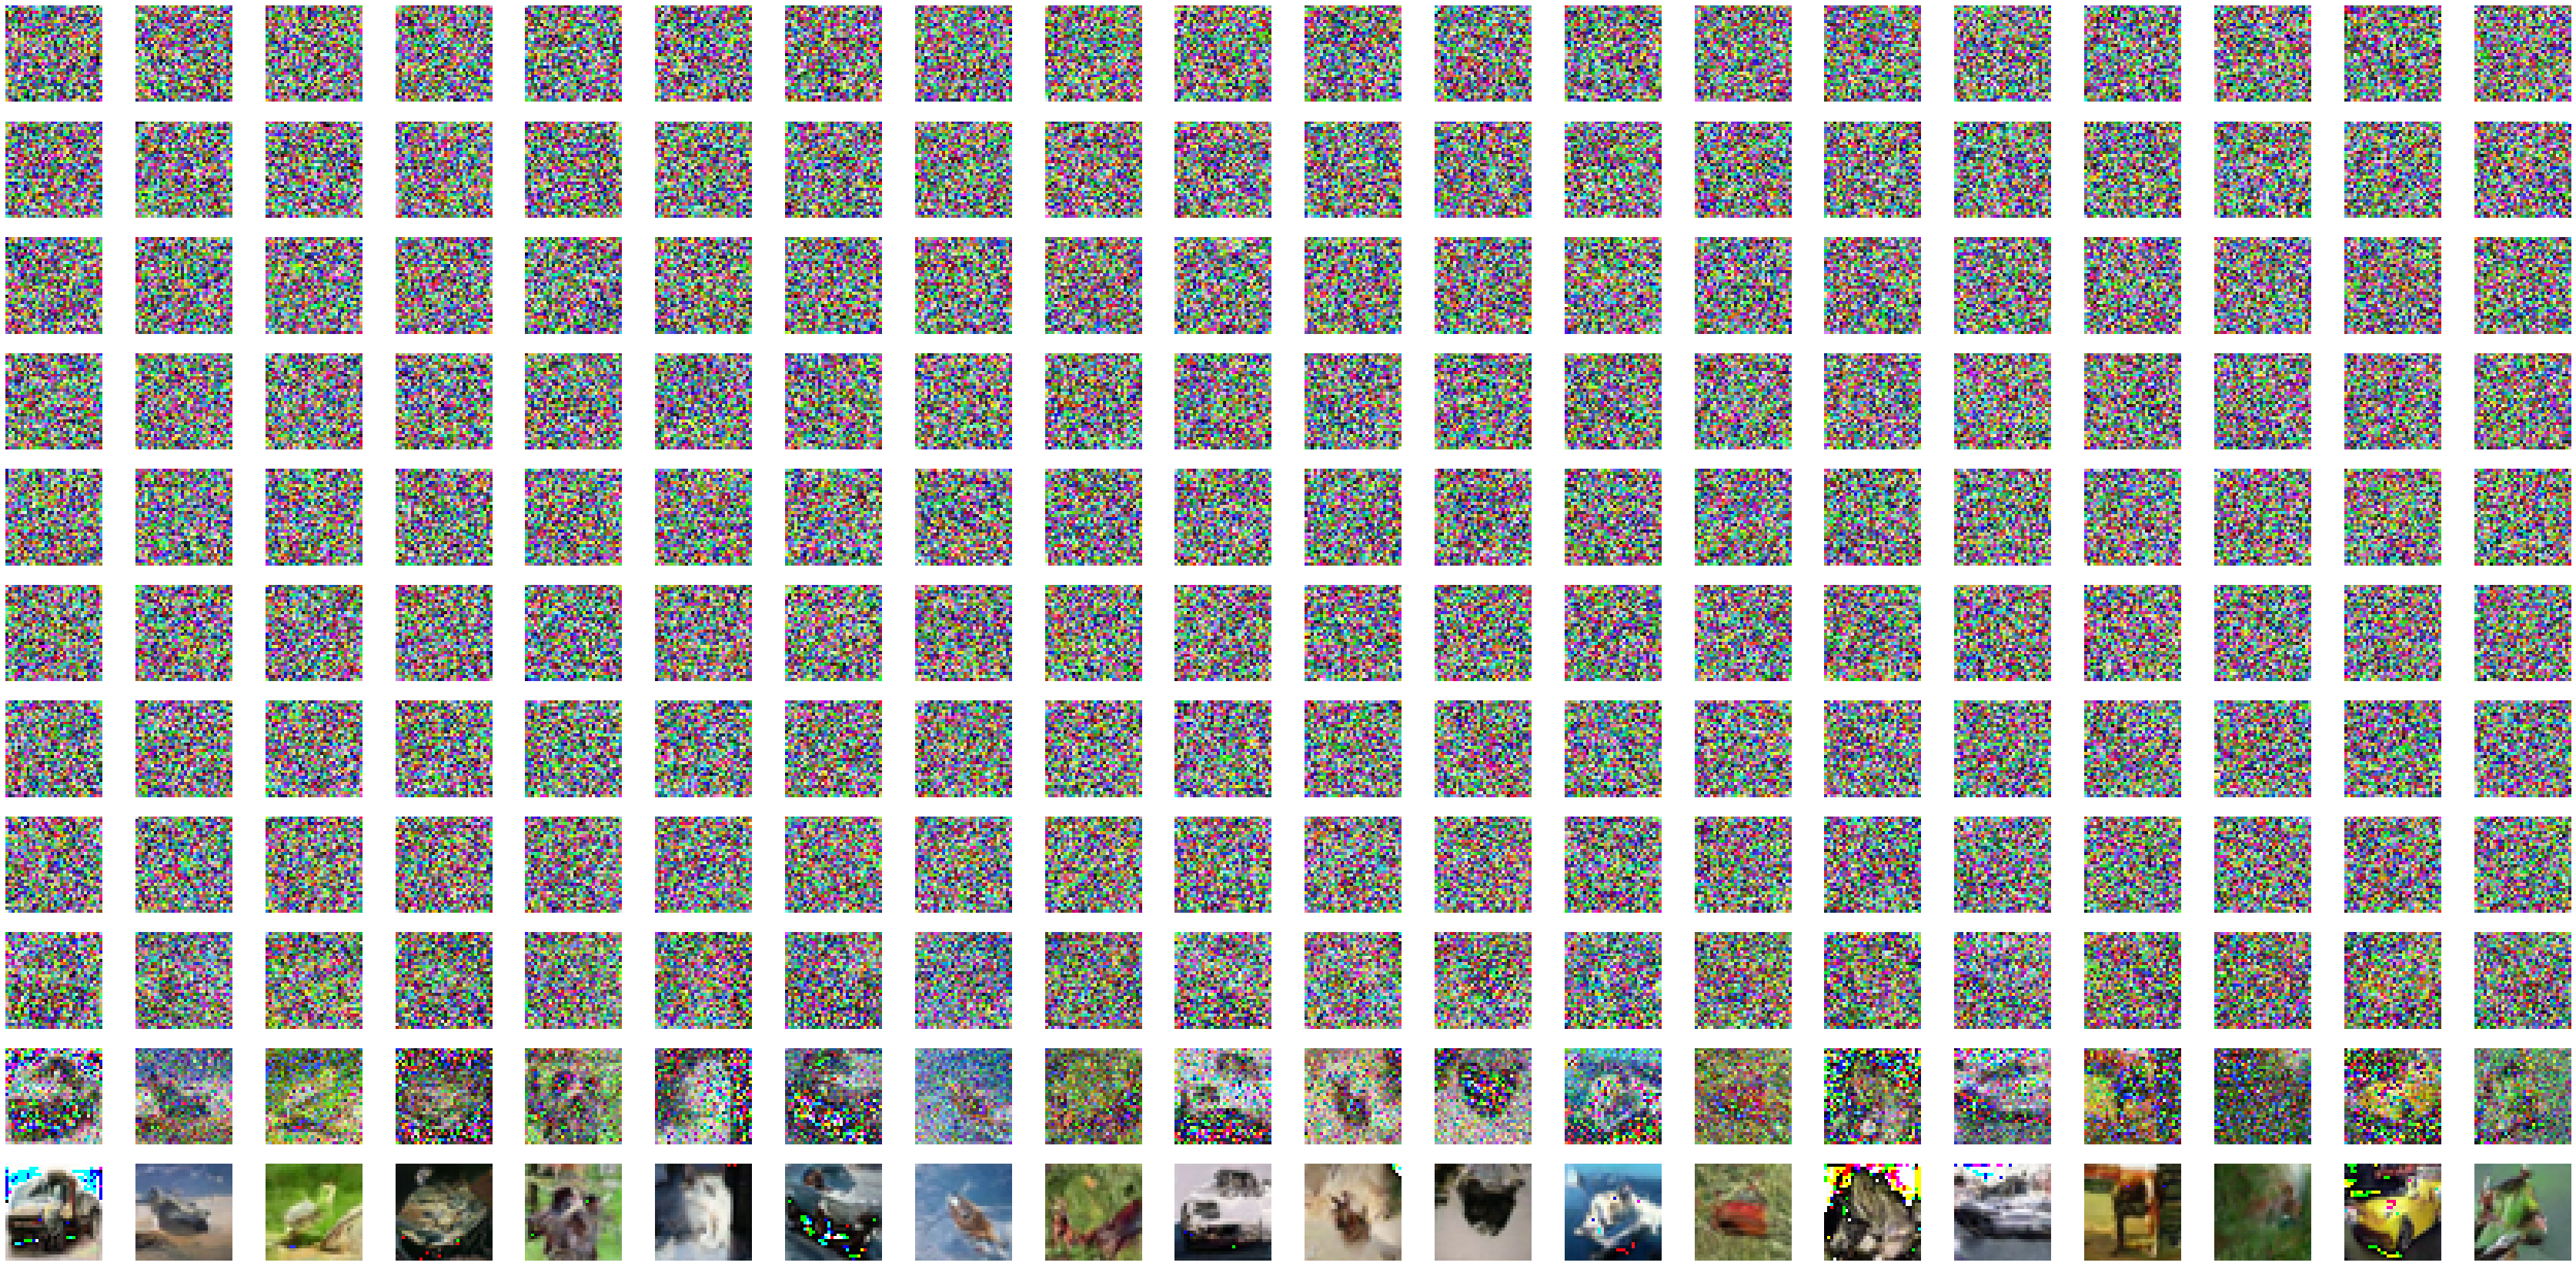

In [12]:
from torchvision.transforms.functional import InterpolationMode
num_batches = 5
num_show = 20
fig, axs = plt.subplots(11, num_show, figsize=(3*num_show, 30))
for j in range(num_batches):
    noise = torch.randn((num_show,3,32,32)).to(device)
    t = (999*torch.ones((num_show,)).cuda()).type(torch.int32)

    t1 = time()
    img, his = diffuser.batch_reverse_diffuse(noise, t, True)
    print("time spent on generation: ", time()-t1)
    image = his[999,:,:,:].to('cpu')
    

    for k in range(10):
        for i, image in enumerate(his[k*100,:,:,:].to('cpu')):
            if i == num_show:
                break
            axs[k][i].imshow(((image.permute(1, 2, 0)+1)*127.5).type(torch.uint8).numpy() )
            axs[k][i].set_axis_off()
            

    for i, image in enumerate(his[999,:,:,:].to('cpu')):
        if i == num_show:
                break
        axs[10][i].imshow(((image.permute(1, 2, 0)+1)*127.5).type(torch.uint8).numpy())
        axs[10][i].set_axis_off()

    fig.show()
    fig.savefig(os.path.join(result_dir, f"progressive_{j}.png"))


Generate `gen_batch * num_batches` images in `gen_img_path`

In [13]:
from torchvision.utils import save_image
from datetime import timedelta


gen_batch = 256
num_batches = 40
gen_img_path = os.path.join(result_dir, 'sample_imgs')

if not os.path.exists(gen_img_path):
    os.mkdir(gen_img_path)
    print("create directory: ", gen_img_path)
print(f"generate {gen_batch * num_batches} samples in ", gen_img_path)

for i in range(num_batches):
    noise = torch.randn((gen_batch,3,32,32)).to(device)
    t = (999*torch.ones((gen_batch,)).cuda()).type(torch.int32)
    t1 = time()
    img, his = diffuser.batch_reverse_diffuse(noise, t, True)
    image = his[999,:,:,:].to('cpu')
    for j, img in enumerate(image):
        save_image(img, os.path.join( gen_img_path ,f"image_{gen_batch*i+j}.png"))
    ellapsed_time = time() - t1
    print(f"{i} the epoch time spent: {ellapsed_time}", f"time left: {timedelta(seconds=ellapsed_time * (num_batches - i))}" )

generate 10240 samples in  /gdrive/MyDrive/CS492I/Final Term project/result/adaptive_sigmoid_20_200/sample_imgs
0 the epoch time spent: 59.46470093727112 time left: 0:39:38.588037
1 the epoch time spent: 59.44763922691345 time left: 0:38:38.457930
2 the epoch time spent: 59.43180513381958 time left: 0:37:38.408595
3 the epoch time spent: 59.42656874656677 time left: 0:36:38.783044
4 the epoch time spent: 59.39664673805237 time left: 0:35:38.279283
5 the epoch time spent: 59.43752121925354 time left: 0:34:40.313243
6 the epoch time spent: 59.39210844039917 time left: 0:33:39.331687
7 the epoch time spent: 59.39997625350952 time left: 0:32:40.199216
8 the epoch time spent: 59.38951230049133 time left: 0:31:40.464394
9 the epoch time spent: 59.335389852523804 time left: 0:30:39.397085
10 the epoch time spent: 59.45953130722046 time left: 0:29:43.785939
11 the epoch time spent: 59.40199065208435 time left: 0:28:42.657729
12 the epoch time spent: 59.40347862243652 time left: 0:27:43.297401


In [14]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchvision.io import read_image
import os, torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import  Compose, ToTensor, Lambda

image_names = os.listdir(gen_img_path)
image_list = []

for f in image_names:
    image_list.append(read_image(os.path.join(gen_img_path, f)).cuda())
gen_images = torch.stack(image_list)


transform = Compose(
    [
        ToTensor(),
        Lambda(lambda x: x.to(device)),
    ]
)

cifar10_test = CIFAR10(root, train=False, transform = transform,download=True)

real_imgs = torch.from_numpy(cifar10_test.data).cuda()
real_imgs = real_imgs.permute(0,3,1,2)

fid = FrechetInceptionDistance(feature=2048).to(device)
inception_score = InceptionScore().to(device)
print("FID device: ", fid.device)
print("IS device: ", inception_score.device)

batch_size = 128
num_batches = (gen_images.shape)[0] // batch_size 
gen_images[:128].shape

for i in range(num_batches):
    fid.update(gen_images[batch_size*i:batch_size*(i+1)], real=False)
    inception_score.update(gen_images[batch_size*i:batch_size*(i+1)])

if gen_images.shape[0] % 128 != 0:
    fid.update(gen_images[batch_size*num_batches:], real=False)    
    inception_score.update(gen_images[batch_size*num_batches:])

num_batches = real_imgs.shape[0] // batch_size
for i in range(num_batches):
    fid.update(real_imgs[batch_size*i:batch_size*(i+1)], real=True)
fid.update(real_imgs[batch_size*num_batches:], real=True)

fid_res = fid.compute()
is_res = inception_score.compute()
print(f"FID score: {fid_res.item()}")
print(f"Inception score: {is_res[0].item()}")


NameError: ignored

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
def interpolation(diffuser, image1, image2, weight_on_img1, latent_time_step):
    """
        diffuser: diffuser model to do latent transform and inversion.
        image1: torch.tensor with size (h,w,3). [-1,1] normalized.
        image2: torch.tensor with size (h,w,3). [-1,1] normalized.
        weight_on_img1: torch.float, between 0 and 1. 
        latent_time_step: diffuser forwards the input image to this time step.
    """
    time = torch.tensor([t]).to(device)
    images = torch.stack([image1, image2]).to(device)
    noised_image = diffuser.get_forward_diffused_image(images, time)
    
    itp_on_latent_space = weight_on_img1*noised_image[0] + (1-weight_on_img1)*noised_image[1]
    reversed = diffuser.batch_reverse_diffuse(itp_on_latent_space.unsqueeze(0), time)
    return reversed



